In [1]:
from __future__ import division, print_function

%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

In [2]:
import os
import ketu
import numpy as np
import matplotlib.pyplot as pl
from transit import SimpleSystem

In [3]:
campaign = 1
# epicid = "201367065"
# epicid = "201912552"
epicid = "201876682"
basepath = "/Users/dfm/data/k2"
light_curve_file = os.path.join(basepath, "lightcurves/c{0}".format(campaign),
                                "{0}00000/{1}000/ktwo{2}-c{3:02d}_lpd-lc.fits"
                                .format(epicid[:4], epicid[4:6], epicid, campaign))

query = dict(
    invert=False,
    light_curve_file=light_curve_file,
    basis_file=os.path.join(basepath, "elcs/c{0}-norm.h5".format(campaign)),
    catalog_file=os.path.join(basepath, "catalogs/epic.h5"),
    nbasis=500,
    initial_time=2015.0,
    skip=50,
    durations=[0.05, 0.1, 0.2],
    min_period=1.,
    max_period=50.,
    npeaks=3,
    # injections=[dict(period=5.275, t0=0.45, radius=0.07, b=0.5, q1=0.5, q2=0.5, e=0.01, pomega=0.0)],
)

In [6]:
pipe = ketu.k2.Data(cache=False)
# pipe = ketu.k2.Inject(pipe, cache=False)
pipe = ketu.k2.Likelihood(pipe, cache=False)
pipe = ketu.OneDSearch(pipe, cache=True)
# pipe = ketu.TwoDSearch(pipe, cache=False)
pipe = ketu.IterativeTwoDSearch(pipe, cache=True)
pipe = ketu.Vetter(pipe, cache=True, clobber=True)
pipe = ketu.FeatureExtract(pipe, cache=True, clobber=True)

In [7]:
r = pipe.query(**query)

Using cached value in IterativeTwoDSearch
Querying Vetter
Using cached value in OneDSearch
Querying Data
Finished querying Data in 0.59s
Querying Likelihood
tau = 8.22055053711
tau = 8.20016479492
tau = 8.20016479492
tau = 3.55120849609
tau = 2.27459716797
tau = 2.27459716797
Finished querying Likelihood in 4.34s
Finished querying Vetter in 10.40s
Querying FeatureExtract
Finished querying FeatureExtract in 0.00s


In [9]:
r.features

array([ (13.027701390561141, 0.1434635798675073, 0.05, -1900.7148963231912, -1900.988217169603, -1895.1630030672497, -inf, -1903.4982258005948, -1900.988217169603, -1897.5493612907308, -1904.6117422247212, 43.503272431113764, -1860.4337214509167, -1867.2624597742877, -3723.9370347067415, 4.934448575466023, 5.790845673301263, 0.5, 0.05000000000000001, 43.503272431113764, 0.5, 0.5, 0.11413895649847662, 5.790845673301263, 201876682, False, False, False, nan, nan, nan, nan, nan, nan),
       (2.669116384498768, 3.313714278057687, 0.2, -1890.4771978994113, -1904.6118568279885, -1892.435661442884, -1902.2415572714146, -1890.7878106260225, -1904.6118568279885, -1896.8423499357252, -1892.9549092874001, 11.476390340275591, -1865.4716467146343, -1869.315921988905, -13063.68107606297, 4.8587554497873775, 9.368134603289867, 0.4941324583805731, 0.2229862916535783, 11.476063022685889, 0.49904060416588064, 0.4998534838671263, 0.05080181867012866, 9.369087209823874, 201876682, False, False, False, nan

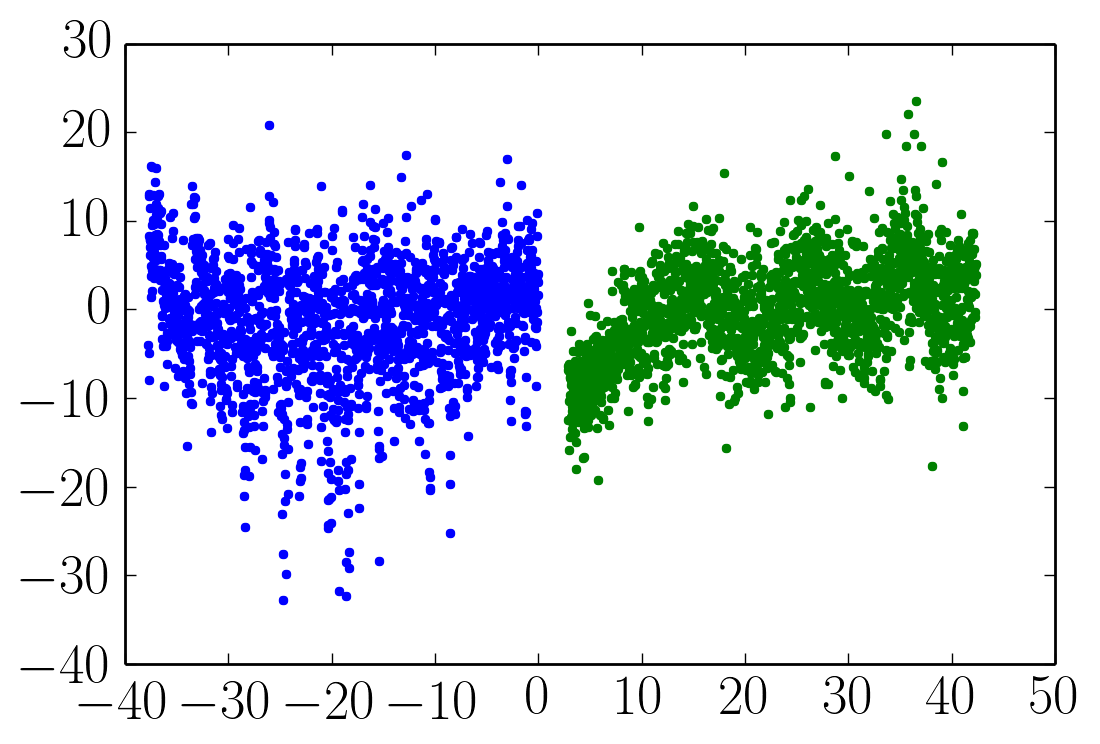

In [10]:
lcs = r.model_light_curves
[pl.plot(lc.time, lc.flux, ".") for lc in lcs];

In [30]:
r.peaks

[{'depth': 13.027701390561141,
  'depth_ivar': 0.1434635798675073,
  'duration': 0.050000000000000003,
  'period': 43.503272431113764,
  'phic_same': -1860.4337214509167,
  'phic_same_second': -1867.2624597742877,
  'phic_variable': -3723.9370347067415,
  's2n': 4.934448575466023,
  't0': 5.7908456733012628},
 {'depth': 2.6691163844987682,
  'depth_ivar': 3.3137142780576871,
  'duration': 0.20000000000000001,
  'period': 11.476390340275591,
  'phic_same': -1865.4716467146343,
  'phic_same_second': -1869.3159219889051,
  'phic_variable': -13063.681076062971,
  's2n': 4.8587554497873775,
  't0': 9.3681346032898674},
 {'depth': 2.1870539332014034,
  'depth_ivar': 4.4607770953292096,
  'duration': 0.10000000000000001,
  'period': 4.9193844655802526,
  'phic_same': -1878.3408657803793,
  'phic_same_second': -1884.0580981953387,
  'phic_variable': -26137.514846044451,
  's2n': 4.6191785947520128,
  't0': 4.1926489668295162}]

(1.2059588331829225, 7.2059588331829225)

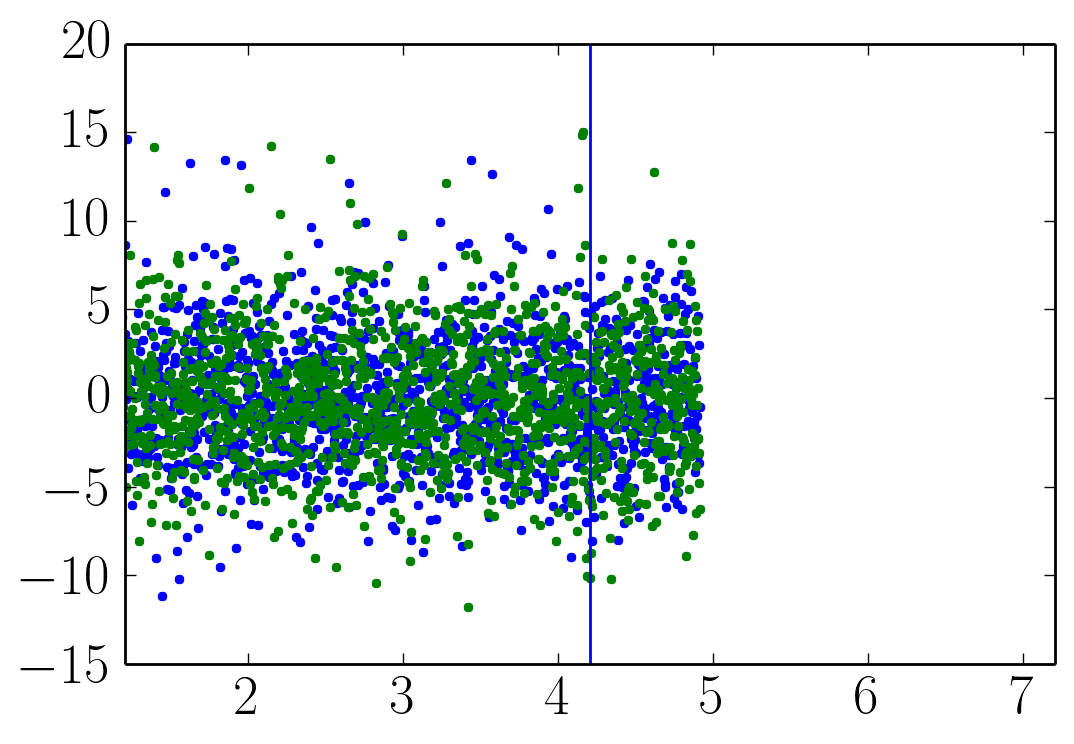

In [15]:
p = r.peaks[2]

s = SimpleSystem(period=p["transit_period"],
                 t0=p["transit_t0"],
                 ror=p["transit_ror"],
                 impact=p["transit_b"],
                 duration=p["transit_duration"],
                 q1=p["transit_q1"],
                 q2=p["transit_q2"])

[pl.plot(lc.time % (p["transit_period"]), lc.flux - lc.predict(lc.flux - 1e3*(s.light_curve(lc.time)-1.0)), ".") for lc in lcs]
pl.gca().axvline(p["transit_t0"]);
pl.xlim(p["transit_t0"]-3, p["transit_t0"]+3)